In [2]:
import random
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import preprocessing, models, layers, applications, optimizers, callbacks, backend

warnings.filterwarnings('ignore')


In [3]:
def is_on_kaggle():
    import os
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        print("Running on Kaggle")
        return True
    else:
        print("Running on Local env")
        return False

In [4]:
root = "/kaggle/input/vehical-4-class-1/dataset" if is_on_kaggle() else "dataset"

data_path = Path(root)
train_dir = data_path / "train"
val_dir = data_path / "validation"
test_dir = data_path / "test"

Running on Kaggle


<center><b><h1>GET DATAFRAME</h1></b></center>

In [5]:
def get_df(dirname: Path):
    data = []
    for label in [d for d in dirname.iterdir() if d.is_dir()]:
        for filename in [f for f in label.iterdir() if f.is_file()]:
            data.append({'label': label.name, 'filepath': filename})
    df = pd.DataFrame(data)
    return df


train_df = get_df(train_dir)
val_df = get_df(val_dir)
test_df = get_df(test_dir)

<center><b><h1>UTILS</h1></b></center>

In [6]:
class MetricsPlotter(callbacks.Callback):
    def __init__(self):
        self.epochs = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch)
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        self.plot_metrics()

    def plot_metrics(self):
        metrics = [m for m in self.history.keys() if not m.startswith('val_')]
        for metric in metrics:
            plt.figure()
            plt.plot(self.epochs, self.history[metric], label=metric)
            plt.plot(self.epochs, self.history['val_' + metric], label='val_' + metric)
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
            plt.title(f'{metric} over epochs')
            plt.savefig(f'{metric}_over_epochs.png')
            plt.close()


def f1_score(y_true, y_pred):
    y_pred = backend.round(y_pred)
    tp = backend.sum(backend.cast(y_true * y_pred, 'float'), axis=0)
    fp = backend.sum(backend.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = backend.sum(backend.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())

    f1 = 2 * p * r / (p + r + backend.epsilon())
    f1 = backend.mean(f1)
    return f1


def scheduler(epoch, lr):
    if epoch < warmup_epochs:
        return initial_learning_rate + (epoch / warmup_epochs) * initial_learning_rate
    else:
        return initial_learning_rate * np.exp(-0.1 * (epoch - warmup_epochs))
    

<center><b><h1>CONST</h1></b></center>

In [7]:
# DATA PREPARATION
CLASSES = len(train_df['label'].unique())
print(f"Number of classes: {CLASSES}")
HEIGHT, WIDTH = 224, 224
BATCH_SIZE = 128
print(f"Batch size: {BATCH_SIZE}")

# TRAIN
EPOCH = 75
print(f"Train in {EPOCH} Epochs")

print(f"\nUsing Warm up Strategy")
initial_learning_rate = 1e-4
OPTIM = optimizers.Adam(learning_rate=initial_learning_rate)
print(f"Using Optimizer Adam with initial leaning rate: {initial_learning_rate}")
LOSS = "categorical_crossentropy"
print(f"Loss : {LOSS}")
METRICS = [f1_score, "accuracy"]
print(f"\nUsing metric F1 & Accuracy")

# EARLY STOPPING
PATIENCE = 15
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

print(f"\nUsing ealy stopping with patience: {PATIENCE}\nmonitor: {early_stopping.monitor}")
# AUTO CHECKPOINT
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# TRACKING METRICS
metrics_plotter = MetricsPlotter()

# LR SCHEDULER
print("\nWarm up Info")
warmup_epochs = int(EPOCH / 100 * 15)
decay_after_warmup = (EPOCH - warmup_epochs)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
print(f"Warm up phase: {warmup_epochs} Epochs")
print(f"decay phase: {decay_after_warmup} Epochs")

# SET UP CALLBACKS
CALLBACKS = [early_stopping, checkpoint, metrics_plotter, lr_scheduler]

Number of classes: 4
Batch size: 128
Train in 75 Epochs

Using Warm up Strategy
Using Optimizer Adam with initial leaning rate: 0.0001
Loss : categorical_crossentropy

Using metric F1 & Accuracy

Using ealy stopping with patience: 15
monitor: val_loss

Warm up Info
Warm up phase: 11 Epochs
decay phase: 64 Epochs


<center><b><h1>VISUALIZE</h1></b></center>

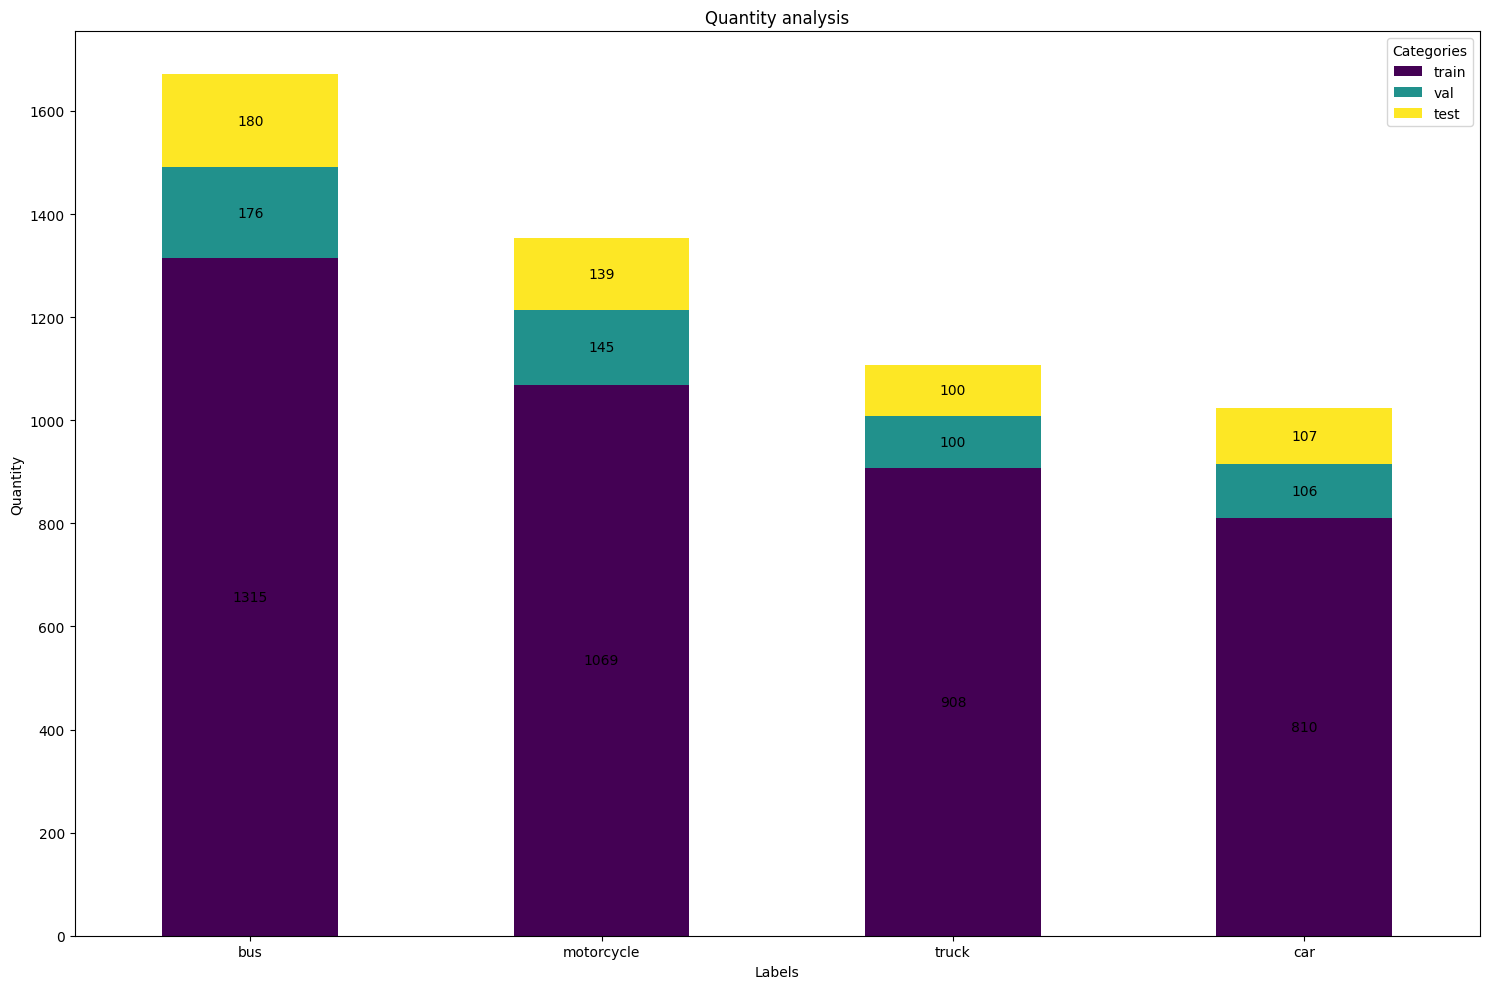

In [8]:
train_counts = train_df['label'].value_counts().rename('train')
val_counts = val_df['label'].value_counts().rename('val')
test_counts = test_df['label'].value_counts().rename('test')

counts_df = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0)

ax = counts_df.plot(kind='bar', stacked=True, figsize=(15, 10), colormap='viridis')
plt.title('Quantity analysis')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Categories')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center')

plt.tight_layout()
plt.show()

In [9]:
def show_random_images(df, n=5):
    labels = df['label'].unique()
    fig, axes = plt.subplots(len(labels), n, figsize=(n * 3, len(labels) * 3))

    if len(labels) == 1:
        axes = [axes]

    for i, label in enumerate(labels):
        files = df[df['label'] == label]['filepath'].tolist()
        sample_files = random.sample(files, min(n, len(files)))

        for j, file in enumerate(sample_files):
            ax = axes[i, j] if len(labels) > 1 else axes[j]
            img = Image.open(file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(label)

        # Fill in any remaining subplots with empty images
        for j in range(len(sample_files), n):
            ax = axes[i, j] if len(labels) > 1 else axes[j]
            ax.axis('off')

    plt.tight_layout()
    plt.show()


show_random_images(train_df, n=5)

<center><b><h1>DATA LOADER</h1></b></center>

In [10]:
train_data_gen = preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_data_gen = preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_data_gen = preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_data_gen.flow_from_directory(
    directory=train_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_data_gen.flow_from_directory(
    directory=val_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_data_gen.flow_from_directory(
    directory=test_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 4100 images belonging to 4 classes.
Found 527 images belonging to 4 classes.
Found 526 images belonging to 4 classes.


<center><b><h1>MODEL</h1></b></center>

In [11]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(CLASSES, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False
    
model = models.Model(inputs=base_model.input, outputs=predictions)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 27,308,868 (104.18 MB)

 Trainable params: 12,594,180 (48.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
model.compile(
    optimizer=OPTIM,
    loss=LOSS,
    metrics=METRICS
)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCH,
    callbacks=CALLBACKS
)

Epoch 1/75


2024-06-26 15:18:50.249036: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-26 15:18:52.189538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.47892, expected 2.11754
2024-06-26 15:18:52.189858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50092: 2.52229, expected 2.16091
2024-06-26 15:18:52.189890: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50149: 2.61231, expected 2.25092
2024-06-26 15:18:52.189909: E external/local_xla/xla/service/gpu/buffer_comparato

16/33 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4710 - f1_score: 0.1279 - loss: 1.1888

2024-06-26 15:20:20.767105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.46848, expected 3.68847
2024-06-26 15:20:20.767158: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.72762, expected 5.94762
2024-06-26 15:20:20.767173: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.00592, expected 5.22591
2024-06-26 15:20:20.767191: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.42362, expected 5.64362
2024-06-26 15:20:20.767203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.34585, expected 4.56585
2024-06-26 15:20:20.767214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.68756, expected 4.90755
2024-06-26 15:20:20.767225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.73264, expected 4.95264
2024-06-26 15:20:20.767235: E external/local_xla/xla/se

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5490 - f1_score: 0.2386 - loss: 1.0606

W0000 00:00:1719415246.335847     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-26 15:20:48.813230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.00564, expected 3.36194
2024-06-26 15:20:48.813297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.21235, expected 4.56865
2024-06-26 15:20:48.813306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 5.39965, expected 4.75595
2024-06-26 15:20:48.813314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.25668, expected 4.61298
2024-06-26 15:20:48.813322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.55266, expected 2.90896
2024-06-26 15:20:48.813330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.84224, expected 4.19854
2024-06-26 15:20:48.813338: E external/local_xla/xla/service/

33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5518 - f1_score: 0.2435 - loss: 1.0551 - val_accuracy: 0.7761 - val_f1_score: 0.7095 - val_loss: 0.5726 - learning_rate: 1.0000e-04
Epoch 2/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7738 - f1_score: 0.7112 - loss: 0.5930 - val_accuracy: 0.7951 - val_f1_score: 0.6937 - val_loss: 0.4733 - learning_rate: 1.0909e-04
Epoch 3/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7878 - f1_score: 0.7327 - loss: 0.5478 - val_accuracy: 0.7875 - val_f1_score: 0.7000 - val_loss: 0.4825 - learning_rate: 1.1818e-04
Epoch 4/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7883 - f1_score: 0.7143 - loss: 0.5460 - val_accuracy: 0.8159 - val_f1_score: 0.7697 - val_loss: 0.4325 - learning_rate: 1.2727e-04
Epoch 5/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8178 - f1_score: 0.7854 - loss: 0.4754 - val_accuracy: 0.8330 - val_f1_score: 0.7636 - val_loss: 0.4197 - learning_rate: 1.3636e-04
Epoch 6/75
33/33 ━━━━━━━━━━━━